<a href="https://colab.research.google.com/github/fcalderan19/TA047R-2C2025-GRUPO02/blob/main/TA047R_TP1_GRUPO2_ENTREGA_EJ4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Análisis de Clustering - Datos de Spotify</center>
#### <center>Ejercicio 4 - Trabajo Práctico 1</center>
#### <center>Organización de Datos - Cátedra Ing. Rodriguez, Juan Manuel</center>

## <center>Clustering de Canciones de Spotify</center>

#Grupo 2 - G2 - Integrantes:

- Calderan, Facundo Andres
- Merlinsky Camins, Mariano Gabriel
- Castellano Bogdan, Benjamin
- Yu, Fernando
- Pons Echeverria, Tomas

### Objetivo
Analizar un conjunto de datos de canciones de Spotify para determinar si es posible formar grupos significativos basados en las características audio de las canciones. El objetivo es:

1. Evaluar la tendencia al clustering de los datos
2. Determinar la cantidad óptima de grupos a formar
3. Visualizar los grupos resultantes
4. Describir las características que definen cada grupo

### Dataset
El dataset contiene información de características audio de canciones extraídas de la API de Spotify, incluyendo métricas como:
- Acousticness: Medida de confianza de si la canción es acústica (0.0 a 1.0)
- Danceability: Qué tan adecuada es la canción para bailar (0.0 a 1.0)
- Energy: Medida de intensidad y actividad percibida (0.0 a 1.0)
- Valence: Medida de positividad musical (0.0 a 1.0)
- Tempo: Tempo estimado en BPM
- Loudness: Volumen general en dB
- Y otras características técnicas...


## 1. Importación de Librerías


In [30]:
# Librerías para manejo de datos
import pandas as pd
import numpy as np

# Librerías para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# Otras librerías
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Configuración de gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)


## 2. Carga y Exploración de Datos


In [31]:
# Descargamos el dataset
!gdown 1i1hyfG4DIgv1r3mVqaJHLMEwyJvnxgAZ


df = pd.read_csv('playlist_spotify.csv')

# Información básica del dataset
print(f"Forma del dataset: {df.shape}")
print(f"Número de canciones: {df.shape[0]}")
print(f"Número de características: {df.shape[1]}")
print(df.head())
print(df.info())
print(df.describe())


Downloading...
From: https://drive.google.com/uc?id=1i1hyfG4DIgv1r3mVqaJHLMEwyJvnxgAZ
To: /content/playlist_spotify.csv
100% 54.4k/54.4k [00:00<00:00, 3.81MB/s]
Forma del dataset: (750, 13)
Número de canciones: 750
Número de características: 13
   acousticness  danceability  duration  energy  instrumentalness  key  \
0         0.713         0.514    100125   0.521          0.816000    8   
1         0.192         0.714    207019   0.614          0.000000    4   
2         0.333         0.630    216200   0.455          0.000004    5   
3         0.601         0.810    136413   0.221          0.210000    5   
4         0.883         0.465    181440   0.459          0.000173    6   

   liveness  loudness  mode  speechiness    tempo  time_signature  valence  
0    0.1120   -14.835     0       0.0444  119.879               4    0.143  
1    0.2630    -6.935     1       0.0319  123.969               4    0.582  
2    0.1270    -9.290     1       0.0292  139.931               4    0.199  
3 

In [32]:
# Análisis de valores faltantes y duplicados
print(df.isnull().sum())
print(f"\nValores duplicados: {df.duplicated().sum()}")


acousticness        0
danceability        0
duration            0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

Valores duplicados: 14


Los datos tienen muy buenas condiciones para ser analizados.

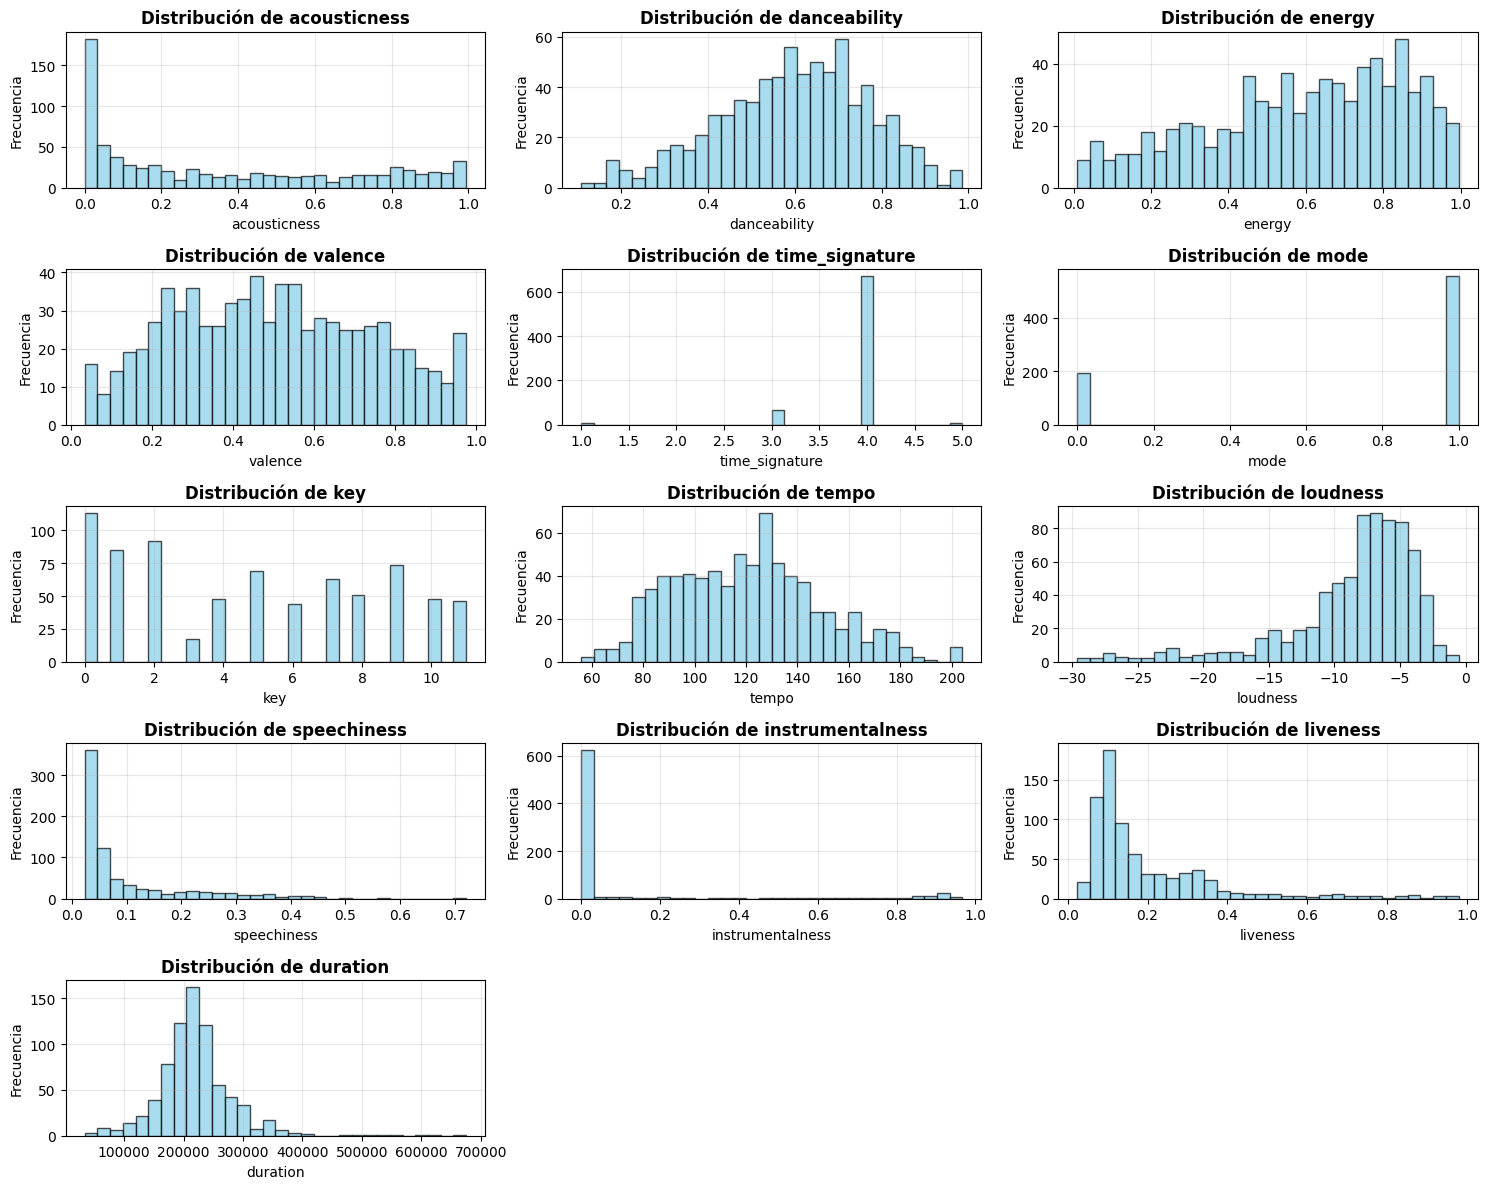

In [33]:
# Visualización de distribuciones de las variables
fig, axes = plt.subplots(5, 3, figsize=(15, 12))
axes = axes.ravel()

variables = ['acousticness', 'danceability', 'energy', 'valence', 'time_signature', 'mode',
              'key','tempo', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 'duration']

for i, var in enumerate(variables):
    if i < len(axes):
        axes[i].hist(df[var], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribución de {var}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Frecuencia')
        axes[i].grid(True, alpha=0.3)

for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 3. Análisis de Tendencia al Clustering

Antes de aplicar algoritmos de clustering, es importante evaluar si los datos tienen una tendencia natural al clustering. Para esto utilizaremos el estadístico de Hopkins.


In [34]:
# Función para calcular el estadístico de Hopkins
def hopkins_statistic(X, m=None):
    """
    Calcula el estadístico de Hopkins para evaluar la tendencia al clustering.

    Parámetros:
    X: array o DataFrame con los datos
    m: número de puntos aleatorios a generar (por defecto 10% del dataset)

    Retorna:
    H: estadístico de Hopkins (0-1)
    """
    import random

    if isinstance(X, pd.DataFrame):
        X = X.values

    n = X.shape[0]  # número de filas
    d = X.shape[1]  # número de columnas

    if m is None:
        m = int(0.2 * n)  # 20% del dataset
    else:
        m = int(m)

    print(f"Número de puntos aleatorios: {m}")

    # Crear objeto para buscar vecinos más cercanos
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(X)

    # Generar índices aleatorios para seleccionar puntos reales
    random.seed(42)  # Para reproducibilidad
    rand_ind = random.sample(range(0, n, 1), m)

    ui = []  # distancias a puntos sintéticos
    wi = []  # distancias a puntos reales

    for j in range(m):
        # Generar punto sintético aleatorio
        u_dist, _ = nbrs.kneighbors(
            np.random.uniform(X.min(axis=0), X.max(axis=0), size=(1, d)),
            2, return_distance=True
        )
        ui.append(u_dist[0][1])

        # Distancia a punto real
        w_dist, _ = nbrs.kneighbors(
            X[rand_ind[j]].reshape(1, -1),
            2, return_distance=True
        )
        wi.append(w_dist[0][1])

    # Calcular estadístico de Hopkins
    H = sum(ui) / (sum(ui) + sum(wi))
    return H



In [35]:
X = df.copy()

# Calcular Hopkins en los datos originales
hopkins_original = hopkins_statistic(X)

print(f"Estadístico de Hopkins {hopkins_original:.4f}")

Número de puntos aleatorios: 150
Estadístico de Hopkins 0.9739


Este valor del estadístico de Hopkins es bastante alto (muy cercano a 1) por lo que indica que estos datos se pueden separar en clusters ofreciendo buenos resultados.

## 4. Preprocesamiento de Datos

Antes de aplicar clustering, es importante estandarizar las variables ya que tienen diferentes escalas y unidades. Esto asegura que todas las características tengan la misma importancia en el algoritmo.


In [36]:
# Estandarización de datos usando StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=variables)

print(X_scaled_df.mean().round(6))
print(X_scaled_df.std().round(6))

# Comparar estadísticas antes y después
print("Datos originales - Rango de valores:")
print(X.describe().loc[['min', 'max']].round(2))
print("\nDatos estandarizados - Rango de valores:")
print(X_scaled_df.describe().loc[['min', 'max']].round(2))


acousticness        0.0
danceability       -0.0
energy             -0.0
valence             0.0
time_signature      0.0
mode               -0.0
key                 0.0
tempo               0.0
loudness            0.0
speechiness        -0.0
instrumentalness    0.0
liveness           -0.0
duration           -0.0
dtype: float64
acousticness        1.000667
danceability        1.000667
energy              1.000667
valence             1.000667
time_signature      1.000667
mode                1.000667
key                 1.000667
tempo               1.000667
loudness            1.000667
speechiness         1.000667
instrumentalness    1.000667
liveness            1.000667
duration            1.000667
dtype: float64
Datos originales - Rango de valores:
     acousticness  danceability  duration  energy  instrumentalness   key  \
min          0.00          0.11   33840.0    0.01              0.00   0.0   
max          0.99          0.99  675360.0    1.00              0.97  11.0   

     livenes

## 5. Determinación del Número Óptimo de Clusters


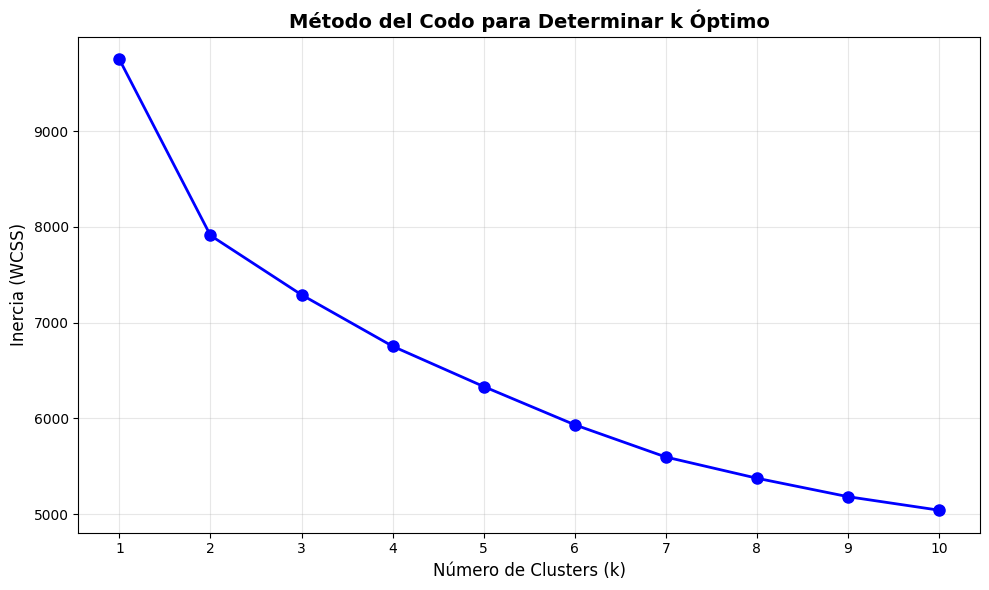

Inercias calculadas: [9750.0, 7910.9, 7290.96, 6753.57, 6332.77, 5933.09, 5596.27, 5374.93, 5182.11, 5040.96]


In [37]:
# Método del Codo (Elbow Method)

# Probar diferentes valores de k
k_range = range(1, 11)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Visualizar el método del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inercia (WCSS)', fontsize=12)
plt.title('Método del Codo para Determinar k Óptimo', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)


plt.tight_layout()
plt.show()

print(f"Inercias calculadas: {[round(i, 2) for i in inertias]}")


k = 2: Silhouette Score = 0.2148
k = 3: Silhouette Score = 0.1379
k = 4: Silhouette Score = 0.1403
k = 5: Silhouette Score = 0.1438
k = 6: Silhouette Score = 0.1444
k = 7: Silhouette Score = 0.1431
k = 8: Silhouette Score = 0.1167
k = 9: Silhouette Score = 0.1213
k = 10: Silhouette Score = 0.1077


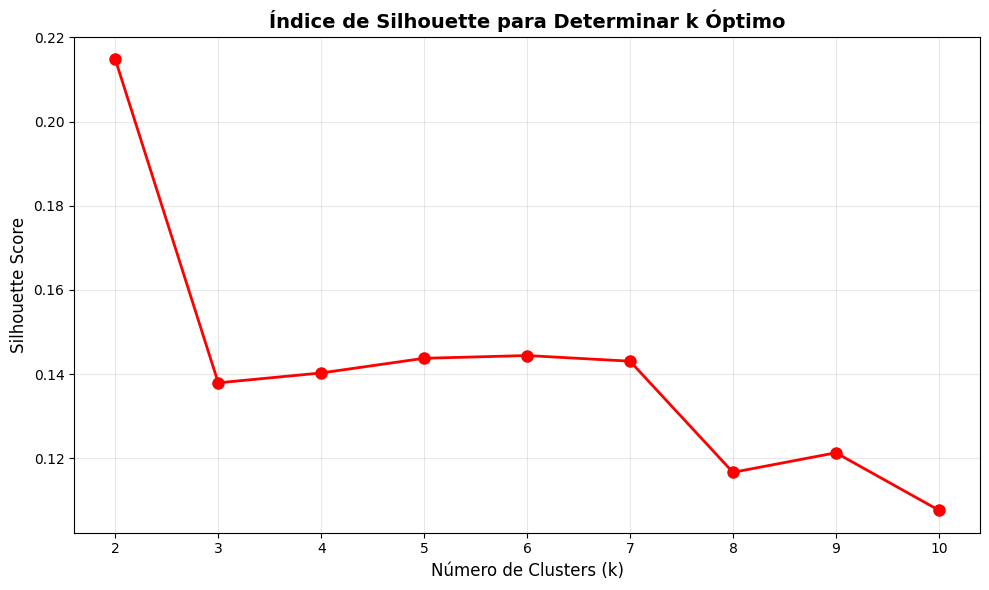


 K óptimo según Silhouette: 2 (Score: 0.2148)


In [38]:
# Índice de Silhouette

silhouette_scores = []

for k in k_range[1:]:  # Empezar desde k=2
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(score)
    print(f"k = {k}: Silhouette Score = {score:.4f}")

# Visualizar los scores de silhouette
plt.figure(figsize=(10, 6))
plt.plot(k_range[1:], silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Índice de Silhouette para Determinar k Óptimo', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range[1:])

optimal_k_silhouette = k_range[1:][np.argmax(silhouette_scores)]
max_score = max(silhouette_scores)

plt.tight_layout()
plt.show()

print(f"\n K óptimo según Silhouette: {optimal_k_silhouette} (Score: {max_score:.4f})")


## 6. Aplicación de K-Means y Visualización de Resultados

Ahora aplicaremos el algoritmo K-Means con el número óptimo de clusters determinado y visualizaremos los resultados.


In [39]:
import joblib
from google.colab import files

k_optimo = 2

kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

joblib.dump(cluster_labels, "modelo_kmeans.joblib")
files.download("modelo_kmeans.joblib")

# Agregar las etiquetas de cluster al DataFrame original
df_resultado = X
df_resultado['cluster'] = cluster_labels

# Estadísticas de cada cluster
distribucion_clusters = pd.Series(cluster_labels).value_counts().sort_index()
print(distribucion_clusters)
for cluster in range(k_optimo):
    porcentaje = (distribucion_clusters[cluster] / len(cluster_labels)) * 100
    print(f"Cluster {cluster}: {distribucion_clusters[cluster]} canciones ({porcentaje:.1f}%)")

# Calcular silhouette score final
silhouette_final = silhouette_score(X_scaled, cluster_labels)
print(f"\n Silhouette Score final: {silhouette_final:.4f}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0    515
1    235
Name: count, dtype: int64
Cluster 0: 515 canciones (68.7%)
Cluster 1: 235 canciones (31.3%)

 Silhouette Score final: 0.2148


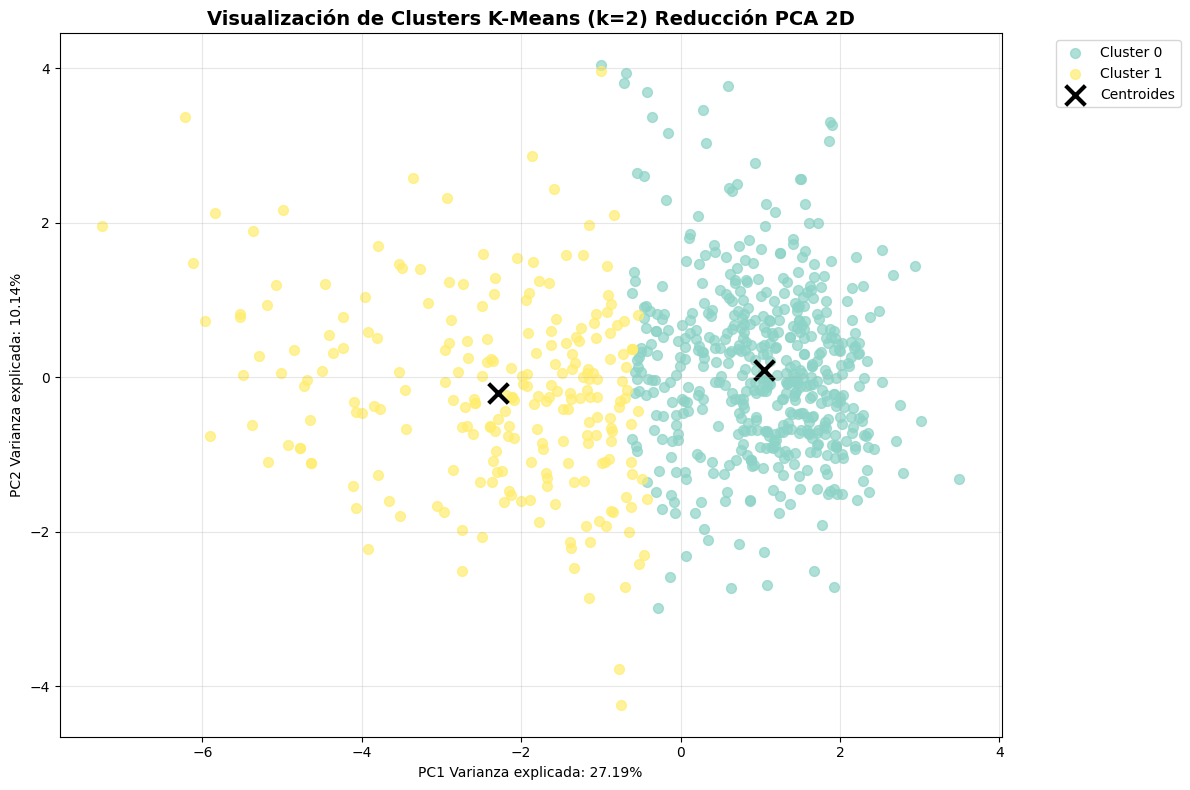

Varianza total explicada: 37.33%


In [40]:
# Visualización de clusters usando PCA para reducción dimensional
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = cluster_labels

plt.figure(figsize=(12, 8))

colors = plt.cm.Set3(np.linspace(0, 1, k_optimo))
for i in range(k_optimo):
    mask = df_pca['cluster'] == i
    plt.scatter(df_pca.loc[mask, 'PC1'], df_pca.loc[mask, 'PC2'],
               c=[colors[i]], label=f'Cluster {i}', alpha=0.7, s=50)

centroids_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
           c='black', marker='x', s=200, linewidths=3, label='Centroides')

plt.xlabel(f'PC1 Varianza explicada: {pca.explained_variance_ratio_[0]:.2%}')
plt.ylabel(f'PC2 Varianza explicada: {pca.explained_variance_ratio_[1]:.2%}')
plt.title(f'Visualización de Clusters K-Means (k={k_optimo}) Reducción PCA 2D', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Varianza total explicada: {pca.explained_variance_ratio_.sum():.2%}")


En este gráfico parece que los datos están bien separados en función al centroide, pero se puede ver como los porcentajes de varianza explicada por estas dos variables del PCA son bastante bajos. Esto implica que se está perdiendo mucha información en esta representación, entonces no podemos afirmar que la separación haya sido acertada. Para eso vamos a analizar las características de cada cluster.

## 7. Análisis de Características que Definen cada Cluster

Ahora analizaremos qué características musicales definen cada grupo de canciones.


         acousticness  danceability  energy  valence  time_signature   mode  \
cluster                                                                       
0               0.178         0.654   0.726    0.558           3.992  0.701   
1               0.750         0.470   0.306    0.364           3.706  0.830   

           key    tempo  loudness  speechiness  instrumentalness  liveness  \
cluster                                                                      
0        5.078  123.483    -6.263        0.120             0.038     0.223   
1        4.285  113.661   -13.433        0.053             0.237     0.160   

           duration  
cluster              
0        214361.773  
1        232715.902  


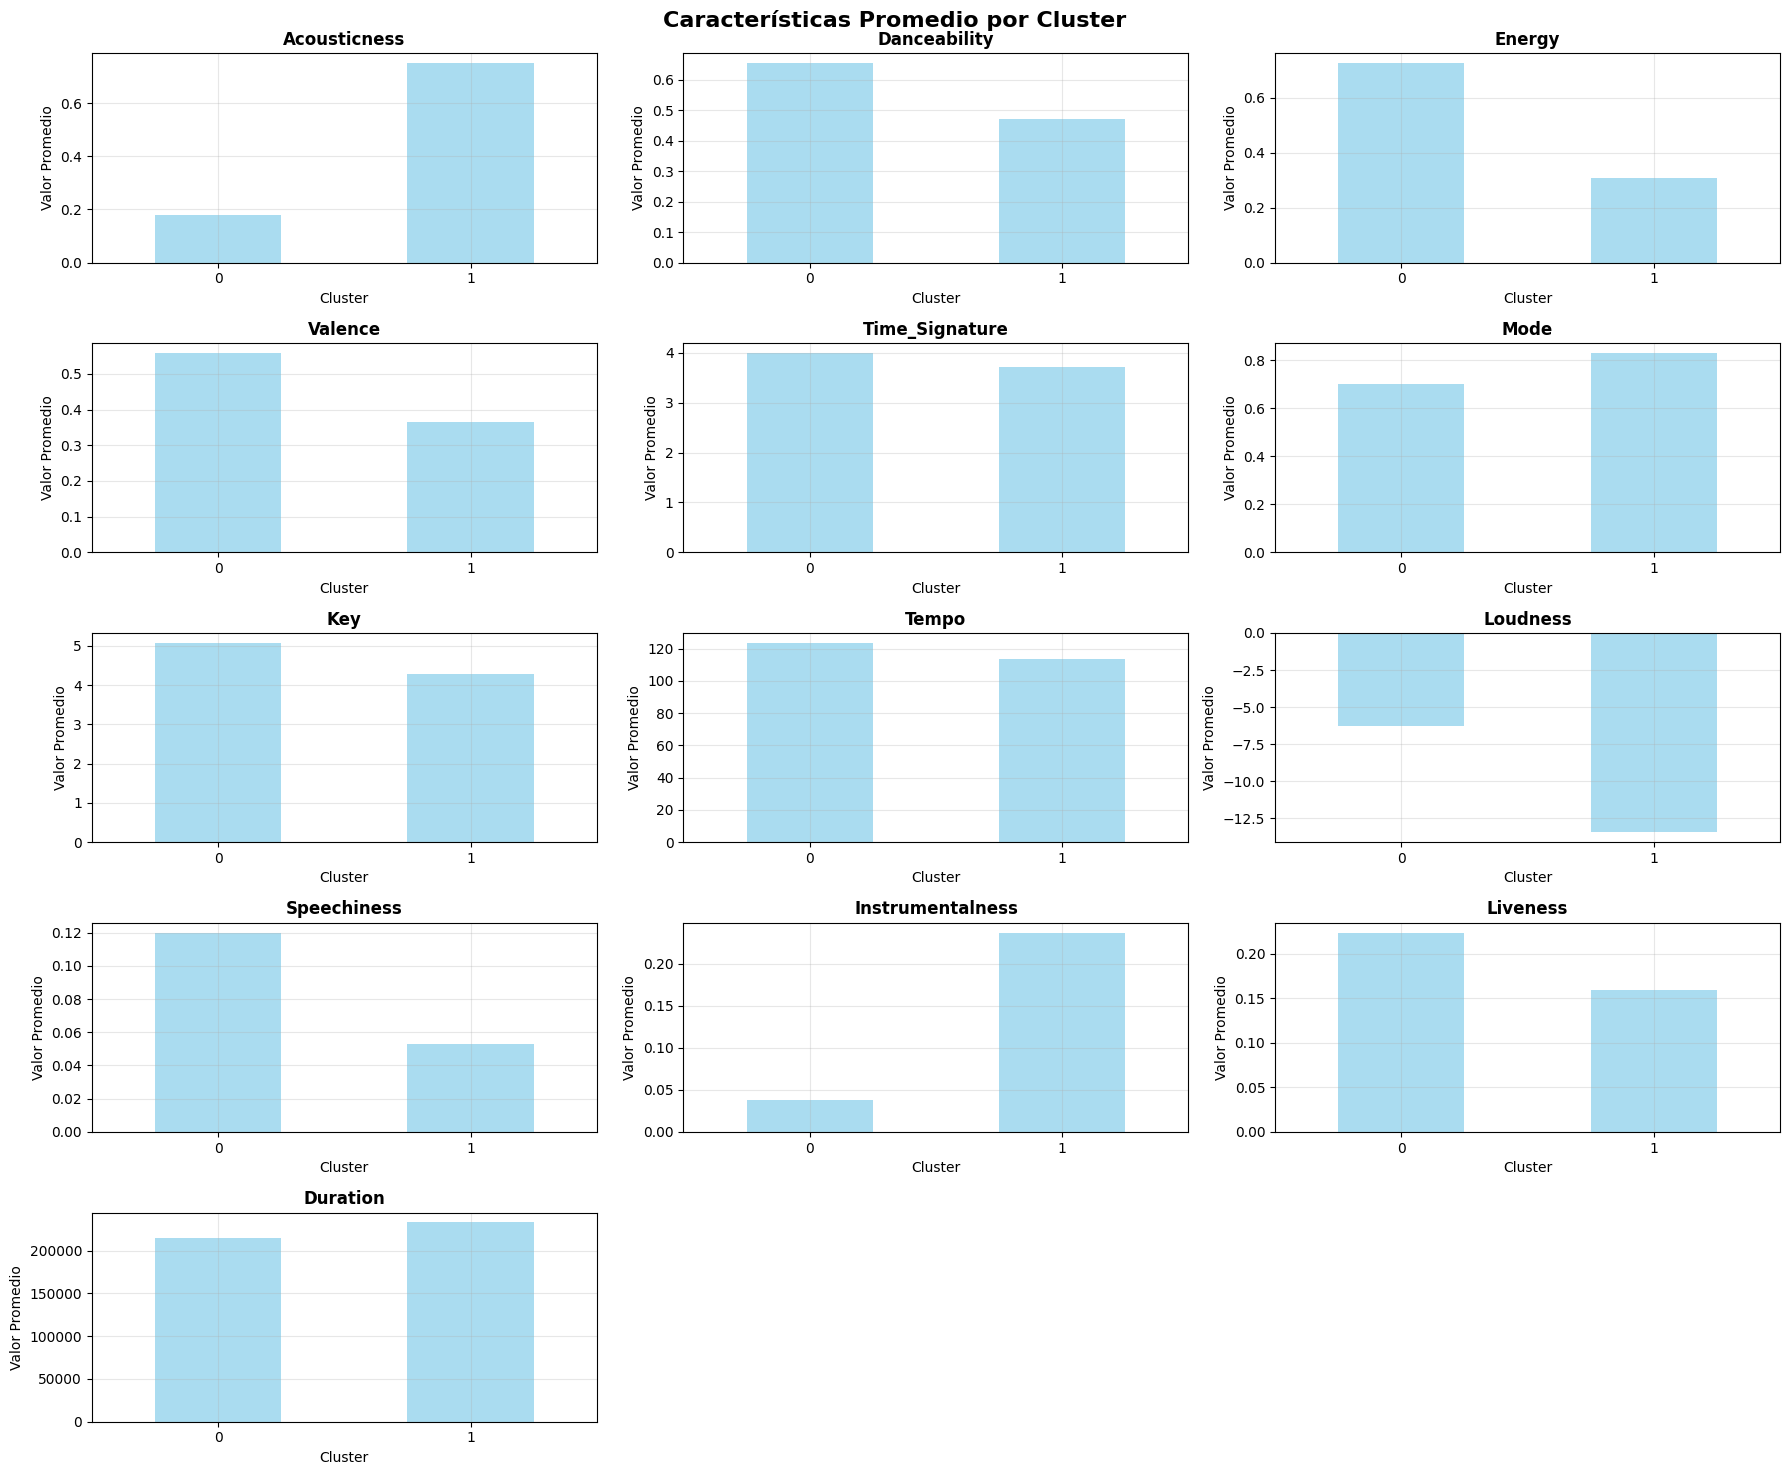

In [41]:
# Análisis de características por cluster

caracteristicas_por_cluster = df_resultado.groupby('cluster')[variables].mean()

print(caracteristicas_por_cluster.round(3))

fig, axes = plt.subplots(5, 3, figsize=(18, 15))
axes = axes.ravel()

for i, var in enumerate(variables):
    if i < len(axes):
        caracteristicas_por_cluster[var].plot(kind='bar', ax=axes[i], color='skyblue', alpha=0.7)
        axes[i].set_title(f'{var.title()}', fontweight='bold')
        axes[i].set_xlabel('Cluster')
        axes[i].set_ylabel('Valor Promedio')
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=0)

for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Características Promedio por Cluster', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


In [42]:
# Análisis detallado de cada cluster

for cluster_id in range(k_optimo):
    cluster_data = df_resultado[df_resultado['cluster'] == cluster_id]

    print(f"CLUSTER {cluster_id} ({len(cluster_data)} canciones - {len(cluster_data)/len(df_resultado)*100:.1f}%)")

    # Características más destacadas
    cluster_means = cluster_data[variables].mean()

    for feature, value in cluster_means.items():
        print(f"{feature}: {value:.3f}")

    print()



CLUSTER 0 (515 canciones - 68.7%)
acousticness: 0.178
danceability: 0.654
energy: 0.726
valence: 0.558
time_signature: 3.992
mode: 0.701
key: 5.078
tempo: 123.483
loudness: -6.263
speechiness: 0.120
instrumentalness: 0.038
liveness: 0.223
duration: 214361.773

CLUSTER 1 (235 canciones - 31.3%)
acousticness: 0.750
danceability: 0.470
energy: 0.306
valence: 0.364
time_signature: 3.706
mode: 0.830
key: 4.285
tempo: 113.661
loudness: -13.433
speechiness: 0.053
instrumentalness: 0.237
liveness: 0.160
duration: 232715.902



# CLUSTER 0 (233 canciones - 31.1%)

Características MÁS ALTAS:

   • tempo: 112.550
   • acousticness: 0.760
   • danceability: 0.470

Características MÁS BAJAS:

   • loudness: -13.463
   • speechiness: 0.052
   • liveness: 0.157

DESCRIPCIÓN:

   Son canciones con baja energía, poco bailables, predominantemente acústica.
   Tempo promedio: 113 BPM

# CLUSTER 1 (517 canciones - 68.9%)

Características MÁS ALTAS:

   • tempo: 123.946
   • energy: 0.726
   • danceability: 0.653

Características MÁS BAJAS:

   • loudness: -6.277
   • instrumentalness: 0.039
   • speechiness: 0.120

DESCRIPCIÓN:

   Canciones con alta energía, moderadamente bailables, estado de ánimo neutral, predominantemente electrónica.
   
   Tempo promedio: 124 BPM


## 8. Conclusiones y Resumen

En conclusión, se puede ver como los datos muestran una estructura clara de clusters. En este datasaet, según los resultados del Silhouette plot (más robusto que el elbow plot) se identificaron 2 grupos musicalmente distintos. En la última ejecución, se ha visto que cada cluster tiene características únicas que lo definen. El análisis permite categorizar canciones por estilo musical